In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import psutil

class BoundBox:
    def __init__(self, ymin, xmin , ymax , xmax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score
    
    
# x1,y1 ----------
#       |        |
#       |        |
#       |        |
#       ----------x2,y2
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

# IoU = (A intersection B) / (A union B)
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap(
        [box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap(
        [box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    if union == 0: 
        return 0
    return float(intersect) / union


def create_box(a):
    return BoundBox(a[0],a[1],a[2],a[3]) # y1, x1, y2, x2 

# row different together
def matrix_confusion(matrix):
    convert =[]
    amount_row = len(matrix)
    amount_col = len(matrix[0])
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            convert.append([i,j,matrix[i][j]])
    df = pd.DataFrame(convert, columns=['row','col','score'])
    # print(df)
    # convert row, col, score to matrix
    convert = df.values
    convert = convert.tolist()
    convert = sorted(convert, key=lambda x: x[2], reverse=True)
    # print(convert)
    
    dict_col = []
    dict_row = []
    values = []
    for i in range(len(convert)):
        if str(convert[i][0]) not in dict_row and str(convert[i][1]) not in dict_col:
            dict_col.append(str(convert[i][1]))
            dict_row.append(str(convert[i][0]))
            values.append(float(convert[i][2]))
    
    values = pd.DataFrame({'row':dict_row, 'col':dict_col, 'score':values})
    # if IoU ≥0.5, classify the object detection as True Positive(TP)
    acc_values = values.loc[values['score'] >= 0.5]
    TP = len(acc_values)
    # if Iou <0.5, then it is a wrong detection and classify it as False Positive(FP)
    FP = len(values) - len(acc_values)
    if amount_col > amount_row:
        FP = FP + (amount_col - amount_row)
    # When a ground truth is present in the image and model failed to detect the object, classify it as False Negative(FN).
    FN = amount_row - amount_col
    # True Negative (TN): TN is every part of the image where we did not predict an object. This metrics is not useful for object detection, hence we ignore TN.
    return TP, FP, FN

def precision_recall(TP, FP, FN):
    # precision = TP / (TP + FP)
    # recall = TP / (TP + FN)
    if TP + FN == 0 and TP + FP ==0:
        return 0,0
    if TP + FP == 0:
        return 0,TP / (TP + FN)
    
    if TP + FN == 0:
        return TP / (TP + FP), 0
    return TP / (TP + FP), TP / (TP + FN)

def f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def accuracy(TP, FP, FN):
    if TP + FP + FN == 0:
        return 0
    return TP / (TP + FP + FN)


TP_,FN_,FP_ = [],[],[]
def scrore_frame_x(dict_trust,dict_predict):
    if len(dict_trust) == 0:
        return 1.0,1.0,1.0,1.0,0,0,0
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    acc_ls = []
    f1_score_ls = []
    precision_ls = []
    recall_ls = []
    
    for key in dict_trust:
        if key in dict_predict:
            matrix_score = []
            
            for i in range(len(dict_trust[key])):
                ls = []
                for j in range(len(dict_predict[key])):
                    ls.append(bbox_iou(create_box(dict_trust[key][i]),create_box(dict_predict[key][j])))
                    
                matrix_score.append(ls)
                
            # matrix_score = np.array(matrix_score)
            # matrix_score = pd.DataFrame(matrix_score)
            # matrix_score.to_csv('./matrix_score2.csv')
            TP, FP, FN = matrix_confusion(matrix_score)
            acc_ls.append(accuracy(TP, FP, FN))
            precision_ls.append(precision_recall(TP, FP, FN)[0])
            recall_ls.append(precision_recall(TP, FP, FN)[1])
            f1_score_ls.append(f1_score(precision_recall(TP, FP, FN)[0],precision_recall(TP, FP, FN)[1]))
            TP_.append(TP)
            FN_.append(FN)
            FP_.append(FP)
    return np.mean(acc_ls), np.mean(precision_ls), np.mean(recall_ls), np.mean(f1_score_ls)
    

def evaluate_count_person(file_trust,file_predict):
    df_trust = pd.read_csv(file_trust)
    df_predict = pd.read_csv(file_predict)
    scores = []
    for frame in range(len(df_trust['frame_x'])):
    # print(df_trust['bounding_box'][0])
    # print(df_predict['bounding_box'][0])        
        import ast
        dict_trust = ast.literal_eval(df_trust['bounding_box'][frame])
        dict_predict = ast.literal_eval(df_predict['bounding_box'][frame])
        scores.append(scrore_frame_x(dict_trust,dict_predict))
        print(scrore_frame_x(dict_trust,dict_predict))
    
    
    process = psutil.Process(os.getpid())
    return np.mean(scores[0]), np.mean(scores[1]), np.mean(scores[2]), np.mean(scores[3]),process.memory_info().rss

print(evaluate_count_person('./trust_csv/2/1.csv','./predict_csv/1.csv'))


(0.12844036697247707, 0.6666666666666666, 0.13725490196078433, 0.22764227642276424)
(0.16494845360824742, 0.6956521739130435, 0.17777777777777778, 0.2831858407079646)
(0.2159090909090909, 0.7037037037037037, 0.2375, 0.35514018691588783)
(0.23529411764705882, 0.8695652173913043, 0.24390243902439024, 0.3809523809523809)
(0.13953488372093023, 0.5714285714285714, 0.15584415584415584, 0.24489795918367346)
(0.24444444444444444, 0.7333333333333333, 0.2682926829268293, 0.3928571428571429)
(0.1411764705882353, 0.75, 0.14814814814814814, 0.24742268041237112)
(0.12222222222222222, 0.5, 0.13924050632911392, 0.21782178217821782)
(0.21428571428571427, 0.8181818181818182, 0.225, 0.35294117647058826)
(0.19753086419753085, 0.7619047619047619, 0.21052631578947367, 0.32989690721649484)
(0.20481927710843373, 0.7083333333333334, 0.2236842105263158, 0.33999999999999997)
(0.13924050632911392, 0.7333333333333333, 0.14666666666666667, 0.24444444444444444)
(0.045454545454545456, 0.36363636363636365, 0.049382716

2746 8918 2288


C:\Users\fancyma\AppData\Local\Temp\ipykernel_20548\2594578215.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(corr.columns)


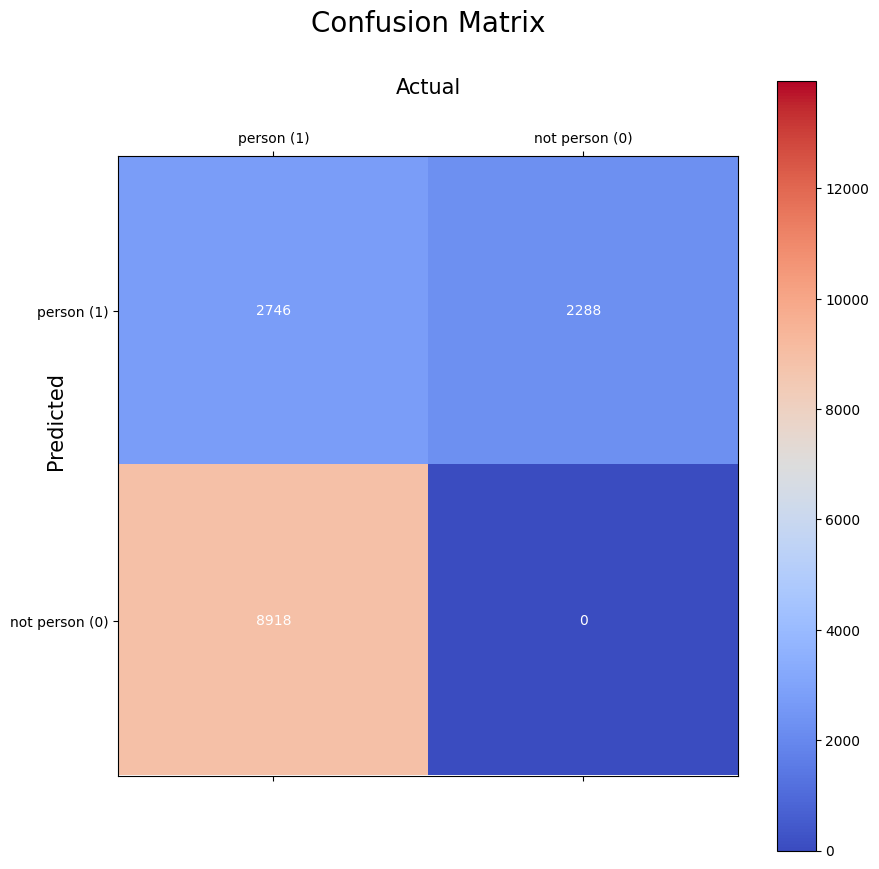

In [83]:
TP_,FN_,FP_ = np.sum(TP_),np.sum(FN_),np.sum(FP_)
print(TP_,FN_,FP_)
# print(np.sum([TP_,FN_,FP_]))
arr= [[TP_,FP_],[FN_,0]]
corr = pd.DataFrame(arr,columns=['person (1)','not person (0)'],index=['person (1)','not person (0)'])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))


cax = ax.matshow(corr,cmap='coolwarm', vmin=0, vmax=13952)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
ax.set_yticks(ticks)
#---print the correlation factor---
for i in range(corr.shape[1]):
 for j in range(2):
    text = ax.text(j, i, round(corr.iloc[i][j],2),ha="center", va="center", color="w")

ax.text(0.5, 1.2, 'Confusion Matrix', horizontalalignment='center', fontsize=20, transform=ax.transAxes)
# actual
ax.text(0.5, 1.1, 'Actual', horizontalalignment='center', fontsize=15, transform=ax.transAxes)
# predicted
ax.text(-0.1,0.5,'Predicted',horizontalalignment='center',fontsize=15,transform=ax.transAxes,rotation=90)
plt.show()